In [116]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

**In this project, you're working for a client who wants to create a model that can predict the price of property in the city of Buenos Aires**

## Prepare Data


## clean

In [2]:
def clean(filepath):
    """
    Data importing and Cleaning Process
    """
    # Read CSV and return the DataFrame
    df = pd.read_csv(filepath)
    # mask the df where country is Argentina and city Buenos Aires
    mask = (df.l1 == "Argentina") & (df["l2"].str.contains("Buenos Aires"))
    df = df[mask]
    # Drop columns
    df.drop(["id", "ad_type", "start_date", "end_date", "created_on", 
             "l4", "l5", "l6", "title", "description"],
            axis=1, inplace=True)
    df["operation_type"] = df["operation_type"].str.replace("Venta", "Sale")
    df["operation_type"] = df["operation_type"].str.replace("Alquiler temporal", "Temporary rental")
    df["operation_type"] = df["operation_type"].str.replace("Alquiler", "Rental")
    
    # drop null rows in price column
    df.dropna(subset = ["price"], inplace=True)
    
    return df

In [3]:
cleaned_train_df = clean("./data/ar_properties_crude.csv")
cleaned_train_df.to_parquet("./data/properties_train_clean.parquet", engine="pyarrow", index=False)

cleaned_valid_df = clean("./data/uy_properties_crude.csv")
cleaned_valid_df.to_parquet("./data/properties_valid_clean.parquet", engine="pyarrow", index=False)

## Import

In [4]:
def wrangle(filepath):
    """
    Data importing and Cleaning Process
    """
    # Read parquet and return the DataFrame
    df = pd.read_parquet(filepath)
    
    return df

In [5]:
df = wrangle("./data/properties_train_clean.parquet")
print(f"df shape: {df.shape}")

df shape: (190659, 15)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190659 entries, 0 to 190658
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              167639 non-null  float64
 1   lon              167526 non-null  float64
 2   l1               190659 non-null  object 
 3   l2               190659 non-null  object 
 4   l3               190509 non-null  object 
 5   rooms            41896 non-null   float64
 6   bedrooms         35358 non-null   float64
 7   bathrooms        154554 non-null  float64
 8   surface_total    27912 non-null   float64
 9   surface_covered  25299 non-null   float64
 10  price            190659 non-null  float64
 11  currency         190458 non-null  object 
 12  price_period     76529 non-null   object 
 13  property_type    190659 non-null  object 
 14  operation_type   190659 non-null  object 
dtypes: float64(8), object(7)
memory usage: 21.8+ MB


In [7]:
df.head()

,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,property_type,operation_type
0,-34.569845,-59.113120,Argentina,Buenos Aires Interior,Luján,8.0,3.0,2.0,241.0,141.0,180000.0,USD,None,Casa,Sale
1,-37.320266,-59.143948,Argentina,Buenos Aires Interior,Tandil,5.0,4.0,2.0,375.0,185.0,130000.0,USD,None,Casa,Sale
2,-37.955460,-57.795685,Argentina,Buenos Aires Interior,General Pueyrredón,6.0,3.0,4.0,1587.0,237.0,185000.0,USD,None,Casa,Sale
3,-34.136105,-59.029284,Argentina,Buenos Aires Interior,Zárate,NaN,NaN,NaN,600.0,NaN,15000.0,USD,None,Lote,Sale
4,NaN,NaN,Argentina,Buenos Aires Interior,Balcarce,3.0,2.0,3.0,NaN,NaN,430000.0,USD,None,Departamento,Sale


## Price and Size

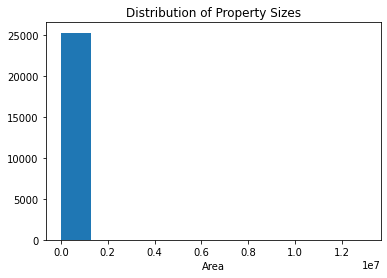

In [8]:
plt.hist(df["surface_covered"])
plt.xlabel("Area")
plt.title("Distribution of Property Sizes");

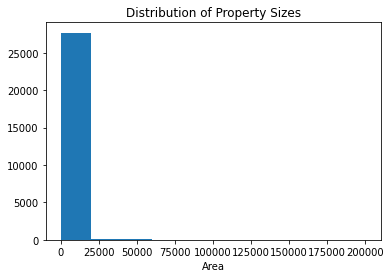

In [9]:
plt.hist(df["surface_total"])
plt.xlabel("Area")
plt.title("Distribution of Property Sizes");

In the histogram above, it suggests that there are outliers in our dataset, This can affect model performance - especially in the sorts of linear models. Let's confirm with the summary statistics.

In [10]:
df[["surface_covered", "surface_total"]].describe()

,surface_covered,surface_total
count,2.529900e+04,27912.000000
mean,7.792096e+02,892.741545
std,8.232749e+04,6596.365480
min,1.000000e+00,0.000000
25%,4.200000e+01,47.000000
50%,7.000000e+01,90.000000
75%,1.330000e+02,340.000000
max,1.300000e+07,200000.000000


The data shows that most of the properties are smaller than 140 square metres of covered surface, there some that are several thousand square meters.

We need to remove observations that are outliers in the surface covered or surface_total column. Specifically all observations should fall between 0.1 and 0.9 quantiles for surface_covered or surface_total.

In [11]:
df["surface_covered"].quantile([0.1, 0.9])

0.1     30.0
0.9    240.0
Name: surface_covered, dtype: float64

In [12]:
df["surface_total"].quantile([0.1, 0.9])

0.1     33.0
0.9    940.0
Name: surface_total, dtype: float64

In [13]:
low, high = df["surface_covered"].quantile([0.1, 0.9])
print(low, high)

30.0 240.0


In [14]:
# creating mask for the data between low and high
# and adding this to our wrangle function
low, high = df["surface_covered"].quantile([0.1, 0.9])
mask_area = df["surface_covered"].between(low, high)
df[mask_area].head()

,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,property_type,operation_type
0,-34.569845,-59.113120,Argentina,Buenos Aires Interior,Luján,8.0,3.0,2.0,241.0,141.0,180000.0,USD,None,Casa,Sale
1,-37.320266,-59.143948,Argentina,Buenos Aires Interior,Tandil,5.0,4.0,2.0,375.0,185.0,130000.0,USD,None,Casa,Sale
2,-37.955460,-57.795685,Argentina,Buenos Aires Interior,General Pueyrredón,6.0,3.0,4.0,1587.0,237.0,185000.0,USD,None,Casa,Sale
5,-37.156749,-56.892458,Argentina,Buenos Aires Costa Atlántica,Cariló,6.0,NaN,3.0,218.0,218.0,420000.0,USD,Mensual,Casa,Sale
6,-38.247281,-57.834585,Argentina,Buenos Aires Costa Atlántica,Miramar,3.0,2.0,1.0,1200.0,80.0,80000.0,USD,None,Casa,Sale


In [15]:
## Just re-writing the wrangle  function just for demonstration
## Should have updated the one above

def wrangle(filepath):
    """
    Data importing and Cleaning Process
    """
    # Read parquet and return the DataFrame
    df = pd.read_parquet(filepath)
    
    # Remove outliers by `surface_covered and surface_total`
    low, high = df["surface_covered"].quantile([0.1, 0.9])
    mask_area = df["surface_covered"].between(low, high)
    
    low, high = df["surface_total"].quantile([0.1, 0.9])
    mask_area_toal = df["surface_total"].between(low, high)
    
    df = df[mask_area & mask_area_toal]
    
    return df

In [16]:
df = wrangle("./data/properties_train_clean.parquet")
print(f"df shape: {df.shape}")

df shape: (16315, 15)


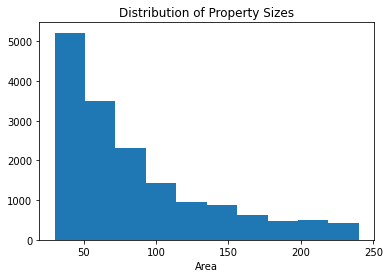

In [17]:
plt.hist(df["surface_covered"])
plt.xlabel("Area")
plt.title("Distribution of Property Sizes");

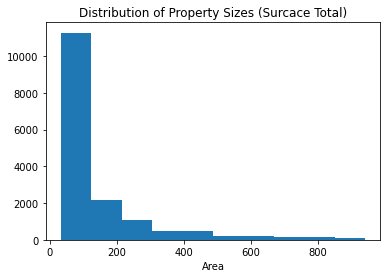

In [18]:
plt.hist(df["surface_total"])
plt.xlabel("Area")
plt.title("Distribution of Property Sizes (Surcace Total)");

### Relationship between surface area and price


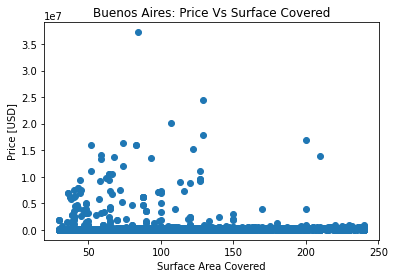

In [19]:
plt.scatter(x=df["surface_covered"], y=df["price"])
plt.xlabel("Surface Area Covered")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price Vs Surface Covered");

In [20]:
df["surface_covered"].corr(df["price"])

0.06280732937388651

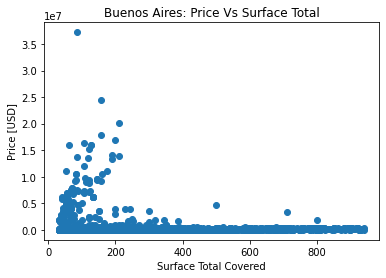

In [21]:
plt.scatter(x=df["surface_total"], y=df["price"])
plt.xlabel("Surface Total Covered")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price Vs Surface Total");

In [22]:
df["surface_total"].corr(df["price"])

0.026306958845406896

The plot suggest there's a very low positive correlation between price and surface covered. This means surface covered is not a very good feature to predict price with.

### Split: Splitting data into a feature matrix (features to use to make predictions) and target vector (feature you want to predict)

In [23]:
# Taking a single feature (surface_covered)
features = ["surface_covered"]
target = "price"
X_train = df[features]
y_train = df[target]

In [24]:
X_train.shape

(16315, 1)

In [25]:
y_train.shape

(16315,)

## Build Model
### Baseline

In [26]:
y_mean = y_train.mean()
y_mean

155467.63407906835

Now that we the one prediction that our dumb model will always make, we need to make a list that repeats for every prediction in our dataset

In [27]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[155467.63407906835,
 155467.63407906835,
 155467.63407906835,
 155467.63407906835,
 155467.63407906835]

Baseline mean absolute error for your predictions in y_pred_baseline as compared to the true targets in y

In [28]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 155467.63
Baseline MAE: 137780.44


What does this information tell us?. If we always predicted that the price of the local commercial property is `$155467.634`, our predictions would be off by an average of `$137780.44`. It also tells us that our model needs to have mean absolute error below `$137780.44` in order to be successful.

## Iterate

This involves building a model, training it, evaluating it, and then repeating the process until you're happy with the model's performance

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Evaluate

The final step is to evaluate our model. We'll start by seeing how well it performs when making predictions for the data it saw during training

In [30]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([205281.87153004, 245074.59181267, 274919.13202465, 271301.61199896,
       171819.81129236])

In [31]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 124883.14


Good news: Our model beat the baseline by over $10,000! That's a good indicator that it will be helpful in predicting apartment prices. 

But the real test is how the model performs on data that it hasn't seen before, data that we call the test set.
In the future, you'll create your own test set before you train your model, but here we'll use one that's pre-made

In [32]:
X_valid = pd.read_parquet("./data/properties_train_clean.parquet")[features]
X_valid = X_valid.dropna()
X_valid.shape

(25299, 1)

In [33]:
y_pred_valid = model.predict(X_valid[:y_train.shape[0]])
y_pred_valid[:5]

array([205281.87153004, 245074.59181267, 292102.3521467 , 274919.13202465,
       150114.6911382 ])

In [34]:
y_train.shape

(16315,)

In [35]:
mae_valid = mean_absolute_error(y_train, y_pred_valid)
print("Validation MAE:", round(mae_valid, 2))

Validation MAE: 956740.5


The validation mae is way above the baseline mae and training mae. This means that our model doesn't generalize well

### Communicate Results ( y = mx + b)

In [36]:
intercept = round(model.intercept_, 2)
print("Model Intercept:", intercept)

coefficient = round(model.coef_[0], 2)
print('Model coefficient for "surface_covered":', coefficient)

Model Intercept: 77764.29
Model coefficient for "surface_covered": 904.38


In [37]:
print(f"apartment_price = {intercept} + {coefficient} * surface_covered")

apartment_price = 77764.29 + 904.38 * surface_covered


## Price and everything

### Predicting price with size, Location, neighborhood etc

In [119]:
def wrangle(filepath):
    """
    Data importing and Cleaning Process
    """
    # Read parquet and return the DataFrame
    df = pd.read_parquet(filepath)
    
    # Remove outliers by `surface_covered and surface_total`
    low, high = df["surface_covered"].quantile([0.1, 0.9])
    mask_area = df["surface_covered"].between(low, high)
    
    low, high = df["surface_total"].quantile([0.1, 0.9])
    mask_area_toal = df["surface_total"].between(low, high)
    
    df = df[mask_area & mask_area_toal]
    
    # Columns to drop
    drop_columns = ["currency", "price_period", "l1", "l2", "l3"]
    df.drop(columns=drop_columns, inplace=True)
    
    # Drops columns with multicollinearity
    multicollinearity_cols = ["bathrooms", "bedrooms", "surface_total"]
    df.drop(columns=multicollinearity_cols, inplace=True)
    
    return df

In [120]:
df = wrangle("./data/properties_train_clean.parquet")
print(f"df shape: {df.shape}")

df shape: (16315, 7)


In [121]:
df.head()

,lat,lon,rooms,surface_covered,price,property_type,operation_type
0,-34.569845,-59.113120,8.0,141.0,180000.0,Casa,Sale
1,-37.320266,-59.143948,5.0,185.0,130000.0,Casa,Sale
5,-37.156749,-56.892458,6.0,218.0,420000.0,Casa,Sale
7,-37.128590,-56.877461,5.0,214.0,90000.0,Casa,Sale
9,-38.122101,-57.598719,4.0,104.0,80000.0,Casa,Sale


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16315 entries, 0 to 190616
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              15116 non-null  float64
 1   lon              15116 non-null  float64
 2   rooms            14041 non-null  float64
 3   surface_covered  16315 non-null  float64
 4   price            16315 non-null  float64
 5   property_type    16315 non-null  object 
 6   operation_type   16315 non-null  object 
dtypes: float64(5), object(2)
memory usage: 1019.7+ KB


In [123]:
df.isna().sum() / len(df)

lat                0.073491
lon                0.073491
rooms              0.139381
surface_covered    0.000000
price              0.000000
property_type      0.000000
operation_type     0.000000
dtype: float64

#### Look out for are categorical columns with low or high cardinality

In [124]:
df.select_dtypes("object").head()

,property_type,operation_type
0,Casa,Sale
1,Casa,Sale
5,Casa,Sale
7,Casa,Sale
9,Casa,Sale


In [125]:
df.select_dtypes("object").nunique()

property_type     10
operation_type     3
dtype: int64

In [126]:
df.property_type.unique()

array(['Casa', 'Departamento', 'Local comercial', 'PH', 'Depósito',
       'Otro', 'Casa de campo', 'Oficina', 'Lote', 'Cochera'],
      dtype=object)

### Look out for multicollinearity

In [127]:
corr = df.select_dtypes("number").drop(columns="price").corr()
corr

,lat,lon,rooms,surface_covered
lat,1.000000,0.002453,0.117135,0.174848
lon,0.002453,1.000000,-0.085603,-0.035604
rooms,0.117135,-0.085603,1.000000,0.723774
surface_covered,0.174848,-0.035604,0.723774,1.000000


<AxesSubplot:>

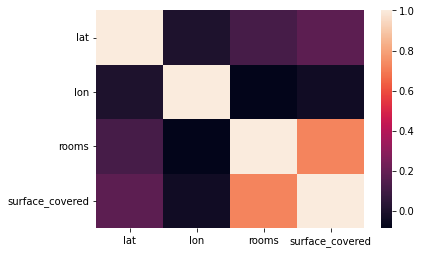

In [128]:
sns.heatmap(corr)

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16315 entries, 0 to 190616
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              15116 non-null  float64
 1   lon              15116 non-null  float64
 2   rooms            14041 non-null  float64
 3   surface_covered  16315 non-null  float64
 4   price            16315 non-null  float64
 5   property_type    16315 non-null  object 
 6   operation_type   16315 non-null  object 
dtypes: float64(5), object(2)
memory usage: 1019.7+ KB


###  Split Data

In [130]:
target = "price"
y_train = df[target]
X_train = df.drop(columns=target)

In [131]:
X_train.shape

(16315, 6)

In [132]:
y_train.shape

(16315,)

### Build Model
#### Baseline

In [133]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

In [134]:
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline).round(2))
print("Baseline RMSE:", (mean_squared_error(y_train, y_pred_baseline) ** .5).round(2) )

Mean apt price: 155467.63
Baseline MAE: 137780.44
Baseline RMSE: 730717.22


### Iterate

In [135]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['property_type', 'operation_type'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Evaluate

In [136]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
rmse_training = (mean_squared_error(y_train, y_pred_training)) ** 0.5

print("Training MAE:", round(mae_training, 2))
print("Training RMSE:", round(rmse_training, 2))

Training MAE: 136975.22
Training RMSE: 719160.44


In [137]:
y_pred_training[:5]

array([472044.00758221, 282066.46920957, 318637.93746684, 297657.7390925 ,
        73570.7650879 ])

In [138]:
features = X_train.columns
X_valid = pd.read_csv("./data/uy_properties_crude.csv")[features]
# X_valid = X_valid.dropna()
X_valid.shape

(50077, 6)

In [139]:
y_pred_valid = model.predict(X_valid[:y_train.shape[0]])
mae_valid = mean_absolute_error(y_train, y_pred_valid)
rmse_valid = (mean_squared_error(y_train, y_pred_valid)) ** 0.5

print("Training MAE:", round(mae_training, 2))
print("Training RMSE:", round(rmse_training, 2))

Training MAE: 136975.22
Training RMSE: 719160.44


### RandomForestRegressor Run with hyperparameters

In [140]:
rgr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestRegressor(random_state=42)
)
print(rgr)

Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])


By default, the number of trees in our forest (n_estimators) is set to 100. That means when we train this classifier, we'll be fitting 100 trees. While it will take longer to train, it will hopefully lead to better performance.

In order to get the best performance from our model, we need to tune its hyperparameter. But how can we do this if we haven't created a validation set? The answer is cross-validation. So, before we look at hyperparameters, let's see how cross-validation works with the classifier we just built.

In [141]:
cv_acc_scores = cross_val_score(rgr, X_train, y_train, cv=5, n_jobs=-1)
print(cv_acc_scores)

[-0.06041296 -0.07019586 -1.60491612  0.16314827 -0.1280333 ]


Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier.

1. For the SimpleImputer, try both the "mean" and "median" strategies.
2. For the RandomForestClassifier, try max_depth settings between 10 and 15, by steps of 10.
3. Also for the RandomForestClassifier, try n_estimators settings between 25 and 100 by steps of 25.

In [142]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestregressor__n_estimators": range(25, 100, 25),
    "randomforestregressor__max_depth": range(10, 50, 10)
    
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestregressor__n_estimators': range(25, 100, 25),
 'randomforestregressor__max_depth': range(10, 50, 10)}

Create a `GridSearchCV` named `model` that includes your regressor and hyperparameter grid. Be sure to use the same arguments for `cv` and `n_jobs` that you used above, and set `verbose` to 1. 

In [143]:
model = GridSearchCV(
    rgr,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 50, 10),
                         'randomforestregressor__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [144]:
# Train model
model.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 50, 10),
                         'randomforestregressor__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [145]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.047534,0.045980,0.026004,0.000941,10,25,mean,"{'randomforestregressor__max_depth': 10, 'rand...",-0.221754,-0.059355,-1.397962,0.120174,-0.191546,-0.350088,0.537646,9
1,1.037583,0.094501,0.033140,0.003960,10,25,median,"{'randomforestregressor__max_depth': 10, 'rand...",-0.110653,-0.051652,-1.160219,0.136557,-0.167711,-0.270736,0.456356,3
2,1.767075,0.054872,0.036486,0.002663,10,50,mean,"{'randomforestregressor__max_depth': 10, 'rand...",-0.114199,-0.051003,-1.320125,0.135154,-0.131122,-0.296259,0.520574,5
3,1.756550,0.079841,0.050082,0.017400,10,50,median,"{'randomforestregressor__max_depth': 10, 'rand...",-0.053105,-0.040283,-1.058376,0.150040,-0.126112,-0.225567,0.426290,2
4,7.306694,0.652373,0.152503,0.042653,10,75,mean,"{'randomforestregressor__max_depth': 10, 'rand...",-0.107100,-0.044605,-1.234488,0.145163,-0.127454,-0.273697,0.489936,4
5,7.962146,1.334157,0.133767,0.053016,10,75,median,"{'randomforestregressor__max_depth': 10, 'rand...",-0.045827,-0.037629,-0.997754,0.150757,-0.121651,-0.210421,0.403775,1
6,3.263892,0.616582,0.138122,0.093306,20,25,mean,"{'randomforestregressor__max_depth': 20, 'rand...",-0.200779,-0.092154,-1.908965,0.126767,-0.217780,-0.458582,0.735522,23
7,2.810247,0.323864,0.067232,0.045002,20,25,median,"{'randomforestregressor__max_depth': 20, 'rand...",0.011604,-0.104504,-2.068562,0.148505,-0.221690,-0.446930,0.820058,20
8,3.687791,0.636359,0.088557,0.022141,20,50,mean,"{'randomforestregressor__max_depth': 20, 'rand...",-0.081742,-0.073951,-1.750034,0.135774,-0.150215,-0.384033,0.689690,18
9,4.177407,0.758433,0.073240,0.016794,20,50,median,"{'randomforestregressor__max_depth': 20, 'rand...",0.105024,-0.092284,-1.847116,0.163054,-0.171621,-0.368589,0.749418,13


#### Extract the best hyperparameters from model


In [146]:
model.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 75,
 'simpleimputer__strategy': 'median'}

In [147]:
model.best_score_

-0.21042076967167644

In [148]:
model.best_estimator_

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['property_type', 'operation_type'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_estimators=75,
                                       random_state=42))])

In [149]:
model.predict(X_train)[:20]

array([189312.10146777, 193793.64000742, 281020.83249574, 276153.25334385,
       131325.62894987,  78292.00246111,  32418.40823557,  92489.60706603,
        66547.55689271,  48940.07532533,  75278.97053374, 146550.41506173,
       319470.95973387,  82760.37821749,  18704.19120834,  84816.94579604,
        93778.12671502,  84915.52719915, 140637.94631412,  25116.34420543])

In [150]:
mae_training = mean_absolute_error(y_train, model.predict(X_train))
rmse_training = (mean_squared_error(y_train, model.predict(X_train))) ** 0.5

print("Training MAE:", round(mae_training, 2))
print("Training RMSE:", round(rmse_training, 2))

Training MAE: 68775.26
Training RMSE: 416425.2


In [151]:
# Save model
with open("model/model-rgr.pkl", "wb") as f:
    pickle.dump(model, f)

In [152]:
model.score(X_train, y_train)

0.6752304314342992